# 机器学习：预测泰坦尼克号灾难的幸存者

From Kaggle: Machine Learning from Disaster

https://www.kaggle.com/c/titanic

# 项目背景

- 泰坦尼克号的沉没是历史上最臭名昭著的海难之一。


- 1912年4月15日，在她的处女航中，被普遍认为“沉没”的RMS泰坦尼克号与冰山相撞后沉没。不幸的是，船上没有足够的救生艇供所有人使用，导致2224名乘客和机组人员中的1502人死亡。


- 尽管幸存有一些运气，但似乎有些人比其他人更有可能生存。

# 项目目标

- 在本项目中，我们将使用乘客数据（即姓名，年龄，性别，社会经济舱等）建立多个预测模型来回答：**“什么样的人更有可能生存？”** 。


- 最终选出最优的算法模型，对泰坦尼克号沉船事故中哪些人会幸存下来进行预测。


- 初步决定采用**`Accuracy(准确率)、F1score`**作为模型表现的评估指标。


- F1score = 2×Precision×Recall / (Precision+Recall)

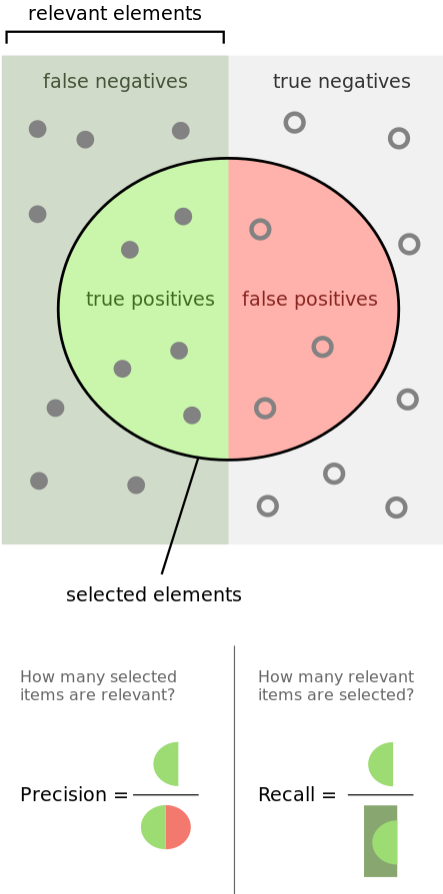

# 项目字典

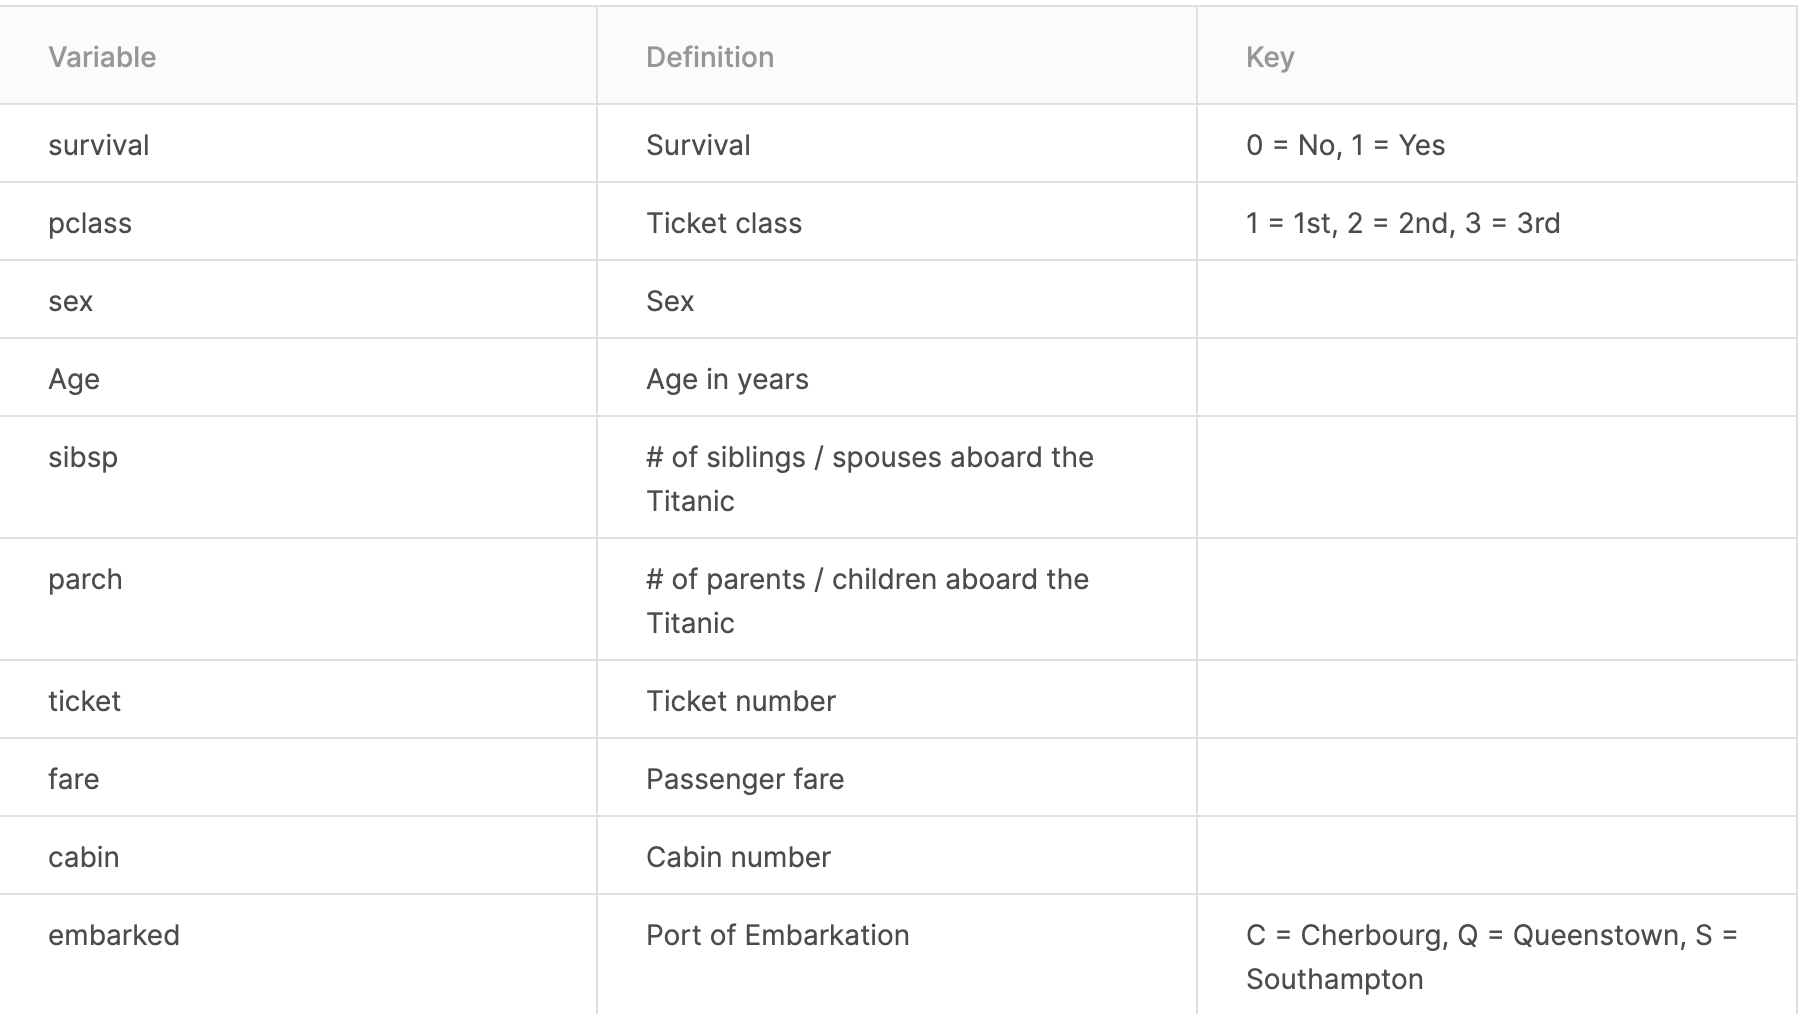

`**Variable Notes**`

- pclass: A proxy for socio-economic status (SES)
    - 1st = Upper
    - 2nd = Middle
    - 3rd = Lower

- age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

- sibsp: The dataset defines family relations in this way...
- Sibling = brother, sister, stepbrother, stepsister
- Spouse = husband, wife (mistresses and fiancés were ignored)

- parch: The dataset defines family relations in this way...
- Parent = mother, father
- Child = daughter, son, stepdaughter, stepson
- Some children travelled only with a nanny, therefore parch=0 for them.

# 数据预处理

## 数据加载

In [2]:
# 导入标准库
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier

from sklearn.metrics import accuracy_score, f1_score, make_scorer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

In [13]:
df = pd.read_csv('titanic_data_train.csv')
df_test = pd.read_csv('titanic_data_test.csv')

In [15]:
df.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [16]:
df1.head(3)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q


## 数据评估

In [10]:
df.shape

(891, 12)

In [12]:
df1.shape

(418, 11)

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [55]:
# 查看各列数据概况
col_list = df.columns
for i in col_list:
    
    print('Column name:',i)
    print('-------------------------------')
    print(df[i].value_counts().nlargest(10))
    print('\n')

Column name: PassengerId
-------------------------------
891    1
293    1
304    1
303    1
302    1
301    1
300    1
299    1
298    1
297    1
Name: PassengerId, dtype: int64


Column name: Survived
-------------------------------
0    549
1    342
Name: Survived, dtype: int64


Column name: Pclass
-------------------------------
3    491
1    216
2    184
Name: Pclass, dtype: int64


Column name: Name
-------------------------------
Smith, Mr. Thomas                                 1
Kimball, Mr. Edwin Nelson Jr                      1
Hansen, Mr. Henrik Juul                           1
Robins, Mrs. Alexander A (Grace Charity Laury)    1
Emanuel, Miss. Virginia Ethel                     1
Strandberg, Miss. Ida Sofia                       1
Hedman, Mr. Oskar Arvid                           1
Rice, Mrs. William (Margaret Norton)              1
Leinonen, Mr. Antti Gustaf                        1
Hamalainen, Mrs. William (Anna)                   1
Name: Name, dtype: int64


Column name

## 数据清理